In [50]:
# import libraries
import pandas as pd
import numpy as np
import collections
import csv
import os
import plotly as py
import squarify
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from errno import EEXIST
from os import makedirs, path

In [13]:
FinalData=pd.DataFrame()
buckets = pd.read_csv('fintech_keywords.csv')
merged_banks = pd.read_csv('merged_data_all_banks.csv')

keywords_dict = {}

for index,row in buckets.iterrows():
    if buckets['Cluster'][index] in keywords_dict:
        keywords_dict[buckets['Cluster'][index]].append(buckets['Keywords'][index]) 
    else:
        keywords_dict[buckets['Cluster'][index]] = [buckets['Keywords'][index]]

if os.path.exists("FinalData.csv"):
    os.remove("FinalData.csv")
    
with open('FinalData.csv', 'w', newline='') as csvFile:
    wr = csv.writer(csvFile, dialect='excel')
    wr.writerow(['Job ID', 'Job Title', 'Bank Name','Fintech','Matched Cluster', 'Matched Words','Number of Words Matched','URL'])

In [14]:
count = 0
for index,row in merged_banks.iterrows():
    count = count + 1
    addtocsv = [count]
    fintech_flag = 'No'
    matched_clusters = []
    matched_words = []
    job_desc = merged_banks['Job Desc'][index]
    addtocsv.append(merged_banks['Job Title'][index])
    addtocsv.append(merged_banks['Bank Name'][index])
    for cluster, keywordlist in keywords_dict.items():
        for keyword in keywordlist:
            if str(keyword) in str(job_desc):
                fintech_flag = 'Yes'
                if cluster not in matched_clusters:
                    matched_clusters.append(cluster)
                matched_words.append(str(keyword))
                
    addtocsv.append(fintech_flag)
    addtocsv.append(",".join(matched_clusters))
    addtocsv.append(",".join(matched_words))
    addtocsv.append(len(matched_words))
    addtocsv.append(merged_banks['URL'][index])
    with open('FinalData.csv', "a", newline='') as csvFile:
            wr = csv.writer(csvFile, dialect='excel')
            try:
                wr.writerow(addtocsv)
            except:
                continue;
csvFile.close()        

In [51]:
# Read CSV for Visualization
df_final_data = pd.read_csv('FinalData.csv', encoding="ISO-8859-1")

In [52]:
df_final_data.head(5)

,Job ID,Job Title,Bank Name,Fintech,Matched Cluster,Matched Words,Number of Words Matched,URL
0,1,sr-tech-manager-information-security-vulnerabi...,Bank Of America,No,NaN,NaN,0,http://careers.bankofamerica.com/job-detail/18...
1,2,sr-tech-manager-information-security-vulnerabi...,Bank Of America,No,NaN,NaN,0,http://careers.bankofamerica.com/job-detail/18...
2,3,agile-product-owner-jersey-city,Bank Of America,No,NaN,NaN,0,http://careers.bankofamerica.com/job-detail/18...
3,4,sr-agile-product-owner-jersey-city,Bank Of America,Yes,cybersecurity,cyber security,1,http://careers.bankofamerica.com/job-detail/18...
4,5,relationship-banker-greenville-ave-spanish-and...,Bank Of America,No,NaN,NaN,0,http://careers.bankofamerica.com/job-detail/18...


In [53]:
df=pd.DataFrame()
bank_1 = "Bank Of America"
count_no = 0
count_yes = 0
for index, row in df_final_data.iterrows():
    bank_name = df_final_data.at[index,"Bank Name"]
    fintech = df_final_data.at[index,"Fintech"]
    if  bank_1 == bank_name:
        if fintech == "Yes":
            count_yes += 1
        else:
            count_no += 1
    else:
        df=df.append({'Bank_Name':bank_1,'Count_yes':count_yes,'Count_no':count_no}, ignore_index=True)
        bank_1 = bank_name
        count_yes = 0
        count_no = 0
        if fintech == "Yes":
            count_yes += 1
        else:
            count_no += 1
df=df.append({'Bank_Name':bank_1,'Count_yes':count_yes,'Count_no':count_no}, ignore_index=True)

In [54]:
# calculation for % of fintech and non-fintech jobs
def total(x,y):
    return round(x+y)
def percent(x,y):
    return round(((x/y) * 100),2)
df['Total'] = df.apply(lambda row: total(row['Count_yes'],row['Count_no']), axis=1)
df['Percent_Yes'] = df.apply(lambda row: percent(row['Count_yes'],row['Total']), axis=1)
df['Percent_No'] = df.apply(lambda row: percent(row['Count_no'],row['Total']), axis=1)

In [55]:
df.tail(2)

,Bank_Name,Count_no,Count_yes,Total,Percent_Yes,Percent_No
22,Huntington Bancshares,250.0,50.0,300,16.67,83.33
23,Comerica Inc,2.0,259.0,261,99.23,0.77


## % of FinTech and Non-FinTech jobs in top US banks

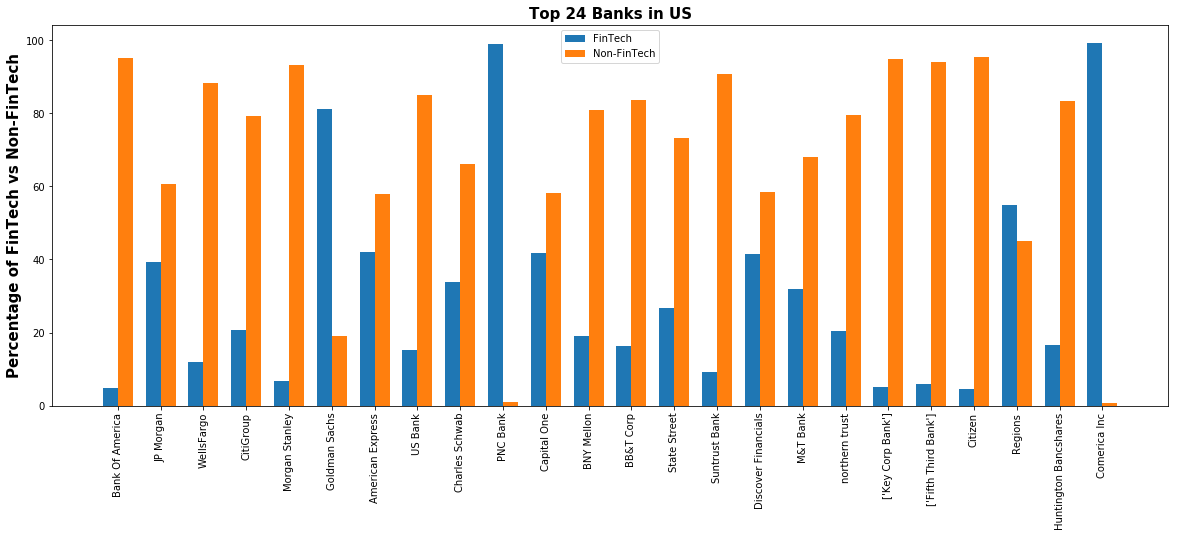

In [69]:
%matplotlib inline
N = 24
Percent_Yes = df['Percent_Yes']
Percent_No = df['Percent_No']

ind = np.arange(N) 
width = 0.35 
f = plt.figure(figsize=(20, 7)) 
plt.bar(ind, Percent_Yes, width, label='FinTech')

plt.bar(ind + width, Percent_No, width,label='Non-FinTech')

plt.ylabel('Percentage of FinTech vs Non-FinTech',fontsize=15,fontweight="bold")
plt.title('Top 24 Banks in US',fontsize=15,fontweight="bold")

plt.xticks(ind + width / 2 , df['Bank_Name'], rotation=90)
plt.legend(loc='best')
plt.show()


try:
    makedirs("visualizations")
except OSError as exc: 
    if exc.errno == EEXIST and path.isdir("visualizations"):
        pass
    else: raise
f.savefig("visualizations/fint_vs_nonfint_US_banks.pdf", bbox_inches='tight')

In [70]:
# Sorted dataframe on Percentage of fintech jobs
df_sorted = df.sort_values(by='Percent_Yes', ascending=False)
df_sorted.head(2)

,Bank_Name,Count_no,Count_yes,Total,Percent_Yes,Percent_No
23,Comerica Inc,2.0,259.0,261,99.23,0.77
9,PNC Bank,9.0,987.0,996,99.10,0.90


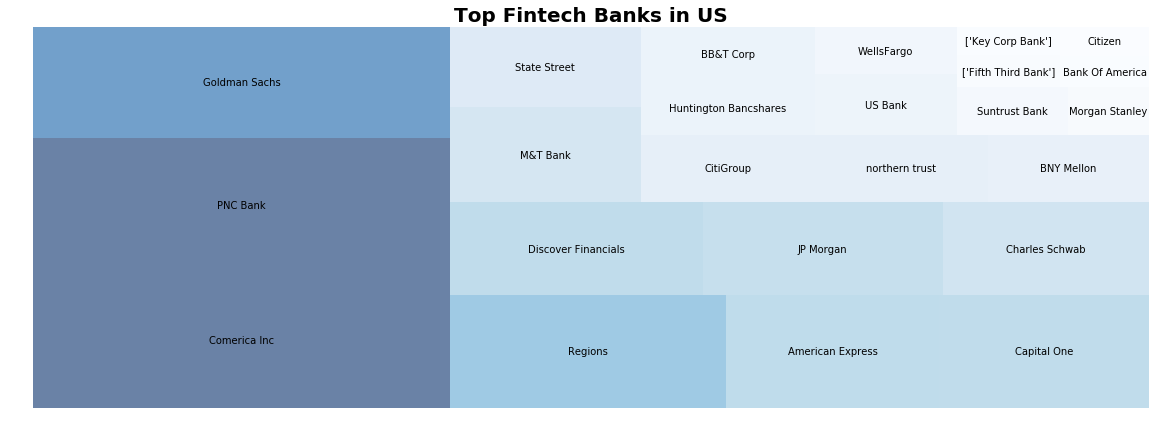

In [71]:
df_new = df_sorted[df_sorted["Percent_Yes"]>0]

#Utilise matplotlib to scale our goal numbers between the min and max, then assign this scale to our values.
norm = matplotlib.colors.Normalize(vmin=min(df_new.Percent_Yes), vmax=max(df_new.Percent_Yes))
colors = [matplotlib.cm.Blues(norm(value)) for value in df_new.Percent_Yes]

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 7)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
squarify.plot(label=df_new.Bank_Name, sizes=df_new.Percent_Yes, color = colors, alpha=.6)
plt.title("Top Fintech Banks in US",fontsize=20,fontweight="bold")

#Remove our axes and display the plot
plt.axis('off')
plt.show()
fig.savefig("visualizations/top_fintech_banks.pdf", bbox_inches='tight')

In [72]:
# creating dataframe containing only fintech jobs
Fintech_only = df_final_data[df_final_data["Fintech"] == "Yes"]
Fintech_only.head(2)

,Job ID,Job Title,Bank Name,Fintech,Matched Cluster,Matched Words,Number of Words Matched,URL
3,4,sr-agile-product-owner-jersey-city,Bank Of America,Yes,cybersecurity,cyber security,1,http://careers.bankofamerica.com/job-detail/18...
11,12,gis-exceptions-governance-manager,Bank Of America,Yes,cybersecurity,cybersecurity,1,http://careers.bankofamerica.com/job-detail/19...


In [73]:
# Making list of clusters
cluster1 = Fintech_only['Matched Cluster']
cluster_list = []
for i in list(cluster1):
    for j in i.split(","):
        cluster_list.append(j)
        
#convert list to dictionary with values and its occurences for matched clusters
word_could_dict =collections.Counter(cluster_list)

# converting to data frame of clusters and corresponding counts
dict1 = {'clusters': list(word_could_dict.keys()), 'counts': list(word_could_dict.values())}
df_cluster = pd.DataFrame.from_dict(dict1)

In [74]:
df_cluster

,clusters,counts
0,cybersecurity,3142
1,blockchain and cryptocurrency,573
2,big data and analytics,5926
3,trading and investments,114
4,other,522
5,digital banking,818
6,payment system,423
7,lending,31
8,mobile technology,52


## Pie chart, of % of different Fintech jobs in market

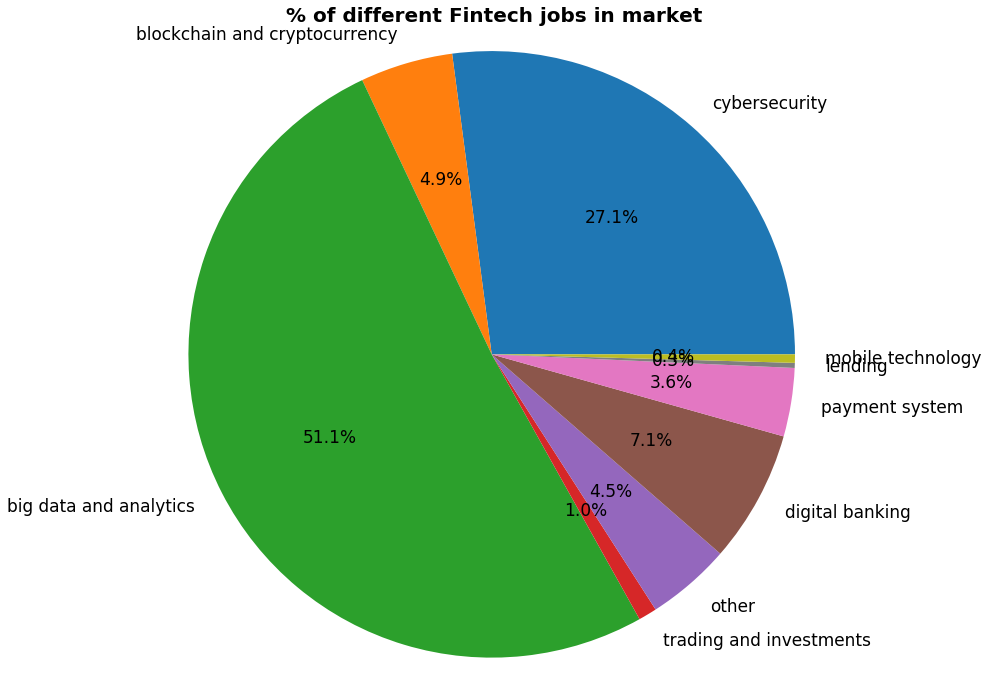

In [75]:
labels = df_cluster['clusters']
sizes = df_cluster['counts']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',  textprops={'fontsize': 17})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle. 
plt.title(" % of different Fintech jobs in market",fontsize=20,fontweight="bold")
fig = plt.gcf()
fig.set_size_inches(12,12)
fig.savefig("visualizations/job_cat_in_fintech.pdf", bbox_inches='tight')

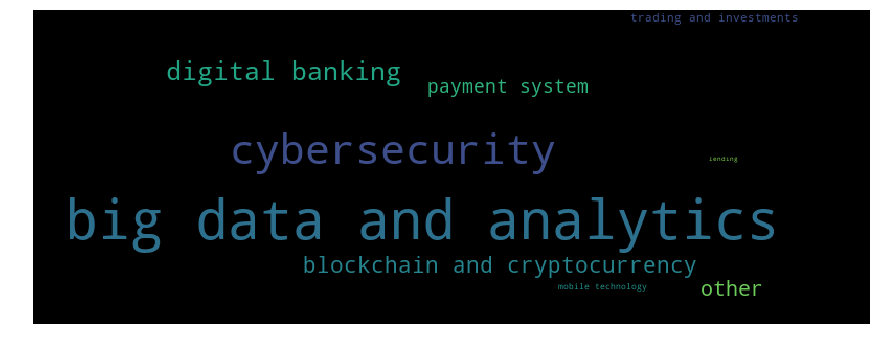

In [76]:
# Creating word cloud from word_could_dict
wordcloud = WordCloud(width = 800, height = 300).generate_from_frequencies(word_could_dict)

A = plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()
A.savefig("visualizations/top_fintech_categories.pdf", bbox_inches='tight')

In [78]:
# Making list of matched key words
cluster2 = Fintech_only['Matched Words']
keywords_list = []
for i in list(cluster2):
    for j in i.split(","):
        keywords_list.append(j)
        
#convert it to dictionary with values and its occurences for matched key words
word_could_dict =collections.Counter(keywords_list)

# converting to data frame of keywords and corresponding counts
dict2 = {'keywords': list(word_could_dict.keys()), 'counts': list(word_could_dict.values())}
df_keywords = pd.DataFrame.from_dict(dict2)

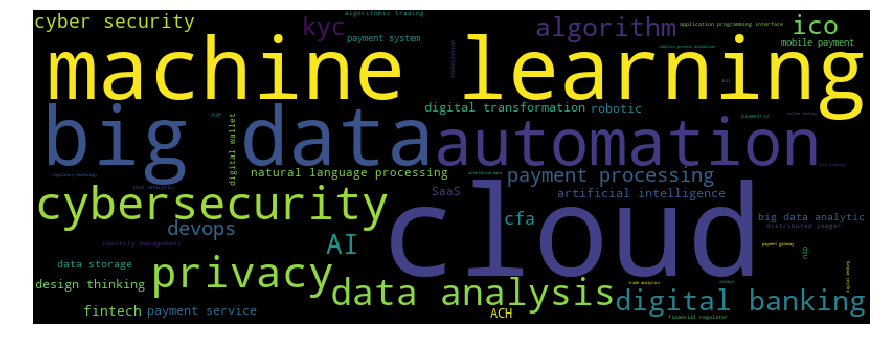

In [79]:
# Creating word cloud from word_could_dict
wordcloud = WordCloud(width = 800, height = 300).generate_from_frequencies(word_could_dict)

B = plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()
B.savefig("visualizations/top_fintech_key_words.pdf", bbox_inches='tight')

In [80]:
# matching clusters to keywords
clu_list = []
key_list = []
buckets = pd.read_csv('fintech_keywords.csv')
for i in list(word_could_dict.keys()):
    try:
        clu_list.append(buckets.loc[buckets.Keywords == i,'Cluster'].values[0])
        key_list.append(i)
    except:
        continue
dict_donut = {'cluster': clu_list, 'keys': key_list}
df_donut = pd.DataFrame.from_dict(dict_donut)
df_donut  = df_donut.sort_values(by='cluster')
df_donut

,cluster,keys
46,big data and analytics,trade analytics
16,big data and analytics,cloud
15,big data and analytics,devops
20,big data and analytics,algorithmic trading
26,big data and analytics,artificial intelligence
12,big data and analytics,big data
11,big data and analytics,AI
39,big data and analytics,big data analytic
45,big data and analytics,application programming interface
9,big data and analytics,data analysis


In [20]:
df_cluster_sorted = df_cluster.sort_values('clusters')

In [21]:
df_cluster_sorted

,clusters,counts
2,big data and analytics,5926
1,blockchain and cryptocurrency,573
0,cybersecurity,3142
5,digital banking,818
7,lending,31
8,mobile technology,52
4,other,522
6,payment system,423
3,trading and investments,114
